# Logic converting bounding boxes around words to bounding boxes around the full sentence  

## Steps

1) Put all of our word bounding box data into a pandas DataFrame() structure (csv)
2) Look at the top left pixel of the first word in a sentence and add the width to get to the top right pixel of the word
3) Check the distance of the top right pixel from the top left pixel of the word directly to its right.
       -If it is > threshold value, then the sentence bounding box should be completed
       -If it is < threshold value, then the two word bounding boxes should be merged


   




In [93]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import PyPDF2
import pytesseract
from pytesseract import Output
from pdf2image import convert_from_path
import pprint

## Download pytesseract instructions

Download Tesseract on your computer - https://sourceforge.net/projects/tesseract-ocr.mirror/files/5.5.0/tesseract-ocr-w64-setup-5.5.0.20241111.exe/download 
- make sure to add C:\Program Files\Tesseract-OCR to your system PATH

Paste this into your terminal to verify intallation worked: tesseract --version

Install python wrapper by pasting this into your terminal: pip install pytesseract Pillow pandas


## Turn pdf into image 

In [94]:
def pdfToImage(pdf_path):
    #pdf_path = r"C:\Users\dkhun\UC Davis\AISC Github repository\BeginnerProjectFallQuarter2025\data\raw_pdfs\textbook_pdf_6.pdf"
    pdf_path = r"C:\Users\Conno\OneDrive\Desktop\textbook_pdf_6.pdf"
    pdf_image = convert_from_path(pdf_path)

    pages = list(pdf_image)
    #pages[0].show()

    pages[0].save('output_page1.png','PNG') #save PIL Image to disk as a PNG so that I can use the file path in cv2.imread below


## Start by getting all of our word bounding box data into a pandas DataFrame()

C:\Users\Conno\AppData\Local\Temp\ipykernel_19148\3283379716.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NeededData['top'] = pd.to_numeric(df_NeededData['top'])
C:\Users\Conno\AppData\Local\Temp\ipykernel_19148\3283379716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NeededData['left'] = pd.to_numeric(df_NeededData['left'])
C:\Users\Conno\AppData\Local\Temp\ipykernel_19148\3283379716.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

Original data
   level  page_num  block_num  par_num  line_num  word_num  left  top  width  \
0      1         1          0        0         0         0     0    0   1533   
1      2         1          1        0         0         0   275  245   1005   
2      3         1          1        1         0         0   275  245   1005   
3      4         1          1        1         1         0   275  245   1005   
4      5         1          1        1         1         1   275  250    137   

   height  conf  text  
0    2132    -1        
1      48    -1        
2      48    -1        
3      48    -1        
4      36    96  AAPA  

Needed data
   left  top  width  height
0     0    0   1533    2132
1   275  245   1005      48
2   275  245   1005      48
3   275  245   1005      48
4   275  250    137      36



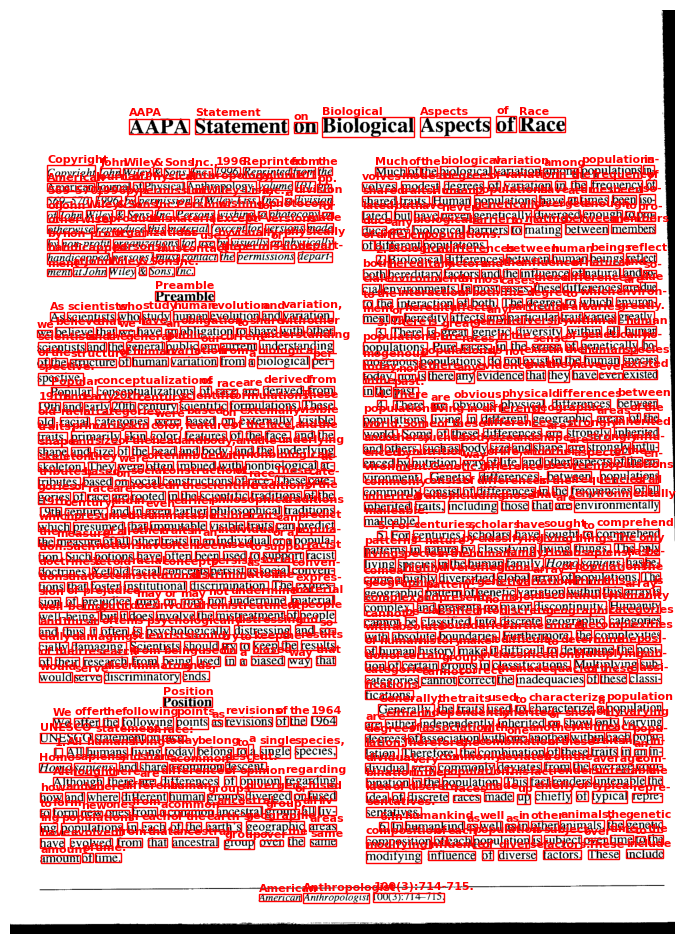

In [95]:

    img = cv2.imread('output_page1.png')
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    data = pytesseract.image_to_data(img, output_type=Output.DICT)

    df = pd.DataFrame(data)
    df_NeededData = df[['left','top','width','height']]

    #make sure all of the numbers are actually numbers and not strings 
    df_NeededData['top'] = pd.to_numeric(df_NeededData['top'])
    df_NeededData['left'] = pd.to_numeric(df_NeededData['left'])
    df_NeededData['width'] = pd.to_numeric(df_NeededData['width'])
    df_NeededData['height'] = pd.to_numeric(df_NeededData['height'])


    print("Original data")
    print(df.head()) #table with original data (all headers)
    print()

    print("Needed data")
    print(df_NeededData.head()) #data with only the headers we want (left, top, width, height)
    print()

    df_NeededData.to_csv('Needed_Data_Unsorted.csv') #converts data into a csv file called data.csv
    csv1 = pd.read_csv('Needed_Data_Unsorted.csv') #gives us a variable that we can call to work with the data in the csv file


    df_NeededData = df_NeededData.sort_values(by=['top', 'left']).reset_index(drop=True) #sorts the data from top to bottom, left to right

    line_threshold_top = 15  # pixel tolerance for same line
    for i in range(0,len(df_NeededData) - 1):
        if(abs( df_NeededData.loc[i, 'top'] - df_NeededData.loc[i+1,'top']) < line_threshold_top): #checks to see if 2 top coords in a row are similar
            df_NeededData.loc[i+1, 'top'] = df_NeededData.loc[i, 'top'] #set the values equal

    df_NeededData = df_NeededData.sort_values(by=['top', 'left']).reset_index(drop=True) #sorts the data from top to bottom, left to right

    line_threshold_left = 15  # pixel tolerance for same line
    for i in range(0,len(df_NeededData) - 1):
        if(abs( df_NeededData.loc[i, 'left'] - df_NeededData.loc[i+1,'left']) < line_threshold_left): #checks to see if 2 top coords in a row are similar
            df_NeededData.loc[i+1, 'left'] = df_NeededData.loc[i, 'left'] #set the values equal


    df_NeededData = df_NeededData.drop_duplicates(subset=['left', 'top', 'width', 'height']).reset_index(drop=True) #deletes all duplicates and resets the index
    #even after everything above some of the bounding boxes are overlapping, so we just want to keep the largest box 
    #below is the code for how to only keep the biggest bounding box and remove the others
    df_NeededData['area'] = df_NeededData['width'] * df_NeededData['height'] # Compute area of each box
    df_NeededData = df_NeededData.sort_values('area', ascending=False) # Sort by area descending so largest box is first within each group
    df_NeededData = df_NeededData.drop_duplicates(subset=['left', 'top'], keep='first')# Drop duplicates keeping largest area box per (left, top)
    df_NeededData = df_NeededData.drop(columns=['area']).reset_index(drop=True) # Optionally, drop the area column afterward


    df_NeededData = df_NeededData.sort_values(by=['top', 'left']).reset_index(drop=True) #sorts the data from top to bottom, left to right


    df_NeededData.to_csv('Needed_Data_Sorted.csv', index=False) #converts data into a csv file called data.csv
    csv2 = pd.read_csv('Needed_Data_Sorted.csv') #gives us a variable that we can call to work with the data in the csv file



    #plot the pdf with bounding boxes
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img_rgb)

    # Draw bounding boxes from your DataFrame
    for idx, row in df.iterrows():
        # Only draw boxes for detected words (optional: filter by confidence)
        if row['conf'] > 0 and isinstance(row['text'], str) and row['text'].strip() != '':
            rect = patches.Rectangle(
                (row['left'], row['top']),
                row['width'],
                row['height'],
                linewidth=1,
                edgecolor='red',
                facecolor='none'
            )
            ax.add_patch(rect)
            # Optionally, add the word as a label
            ax.text(row['left'], row['top'] - 5, row['text'], color='red', fontsize=8, weight='bold')

    plt.axis('off')
    plt.show()
    #done with plot logic ---------------------------------------------



# Logic for the sentence bounding boxes attempt 1

In [96]:



    horizontal_threshold = 20

    resetLine = 0 # restart/save variable
    wordIndex = 1
    lineIndex = 1

    df_NeededData['line #'] = 0
    df_NeededData['word #'] = 0

    #_______________________________________________________________________________________
    line_boxes = []
    for top_val, group in df_NeededData.groupby('top'):
        left = group['left'].min()
        right = (group['left'] + group['width']).max()
        top = group['top'].min()
        bottom = (group['top'] + group['height']).max()
        width = right - left
        height = bottom - top
        line_boxes.append({'left': left, 'top': top, 'width': width, 'height': height})

    line_boxes_df = pd.DataFrame(line_boxes)
    #___________________________________________________________________________________________

    for i in range(0,len(df_NeededData)):

        if i == resetLine:
            RP = df_NeededData.iloc[i]['left'] + df_NeededData.iloc[i]['width']
            df_NeededData.loc[i, 'line #'] = lineIndex
            df_NeededData.loc[i, 'word #'] = wordIndex
            lineIndex += 1 #if we hit a new line we want to index the line
            wordIndex += 1 #if we assign a new line we need to index the word number
            print(f"Line has been reset and the new line is: {lineIndex}")
            continue
        


        else:
            LP = df_NeededData.iloc[i]['left']
            if(abs(LP - RP) < horizontal_threshold):
                df_NeededData.loc[i, 'line #'] = lineIndex
                df_NeededData.loc[i, 'word #'] = wordIndex
                wordIndex += 1 #if the words are on the same line them we want to keep indexing the words
                print(f"Less than horizontal_threshold: {abs(LP-RP)}")
            else:
                resetLine = i+1 #move to the next line 
                wordIndex = 1 #reset the word index if we move to a new line
                print(f"A new line needs to be reset. i = {i}, resetLine = {resetLine}, and wordIndex = {wordIndex}")
                

        RP = df_NeededData.iloc[i]['left'] + df_NeededData.iloc[i]['width']



    print("This is the list of lines")
    df_NeededData.to_csv('Final_Line_Data.csv', index=False) #converts data into a csv file called lineData.csv

    df_csv = pd.read_csv('Final_Line_Data.csv') #gives us a variable that we can call to work with the data in the csv file

    print("Final Line Data")
    print(df_NeededData.head())
    print()



    

Line has been reset and the new line is: 2
A new line needs to be reset. i = 1, resetLine = 2, and wordIndex = 1
Line has been reset and the new line is: 3
Less than horizontal_threshold: 14
Less than horizontal_threshold: 13
Less than horizontal_threshold: 14
Less than horizontal_threshold: 14
Less than horizontal_threshold: 9
A new line needs to be reset. i = 8, resetLine = 9, and wordIndex = 1
Line has been reset and the new line is: 4
Less than horizontal_threshold: 8
Less than horizontal_threshold: 7
Less than horizontal_threshold: 7
Less than horizontal_threshold: 6
Less than horizontal_threshold: 8
Less than horizontal_threshold: 7
Less than horizontal_threshold: 1
Less than horizontal_threshold: 6
A new line needs to be reset. i = 18, resetLine = 19, and wordIndex = 1
Line has been reset and the new line is: 5
A new line needs to be reset. i = 20, resetLine = 21, and wordIndex = 1
Line has been reset and the new line is: 6
Less than horizontal_threshold: 7
Less than horizontal_

# Logic for the sentence bounding boxes attempt 2

In [97]:



    horizontal_threshold = 40  # Tune up or down for your scan

    # Bin top values
    df_NeededData['top_rounded'] = np.round(df_NeededData['top'] / 10) * 10

    df_NeededData.sort_values(['top_rounded', 'left'], inplace=True)
    df_NeededData = df_NeededData.reset_index(drop=True)
    df_NeededData['line #'] = 0
    cur_line_index = 1
    line_boxes = []

    for top_val, group in df_NeededData.groupby('top_rounded'):
        group = group.sort_values('left')
        group_indices = group.index.tolist()
        prev_right = None
        start_idx = 0
        for i, idx in enumerate(group_indices):
            left = df_NeededData.loc[idx, 'left']
            width = df_NeededData.loc[idx, 'width']
            right = left + width
            if prev_right is None:
                prev_right = right
                start_idx = i
                continue
            if left - prev_right > horizontal_threshold:
                sub_group = group.iloc[start_idx:i]
                min_left = sub_group['left'].min()
                max_right = (sub_group['left'] + sub_group['width']).max()
                min_top = sub_group['top'].min()
                max_bottom = (sub_group['top'] + sub_group['height']).max()
                line_boxes.append({'left': min_left, 'top': min_top, 'width': max_right - min_left, 'height': max_bottom - min_top, 'line #': cur_line_index})
                df_NeededData.loc[sub_group.index, 'line #'] = cur_line_index
                cur_line_index += 1
                start_idx = i
            prev_right = right
        sub_group = group.iloc[start_idx:]
        if not sub_group.empty:
            min_left = sub_group['left'].min()
            max_right = (sub_group['left'] + sub_group['width']).max()
            min_top = sub_group['top'].min()
            max_bottom = (sub_group['top'] + sub_group['height']).max()
            line_boxes.append({'left': min_left, 'top': min_top, 'width': max_right - min_left, 'height': max_bottom - min_top, 'line #': cur_line_index})
            df_NeededData.loc[sub_group.index, 'line #'] = cur_line_index
            cur_line_index += 1



# Attempt 3

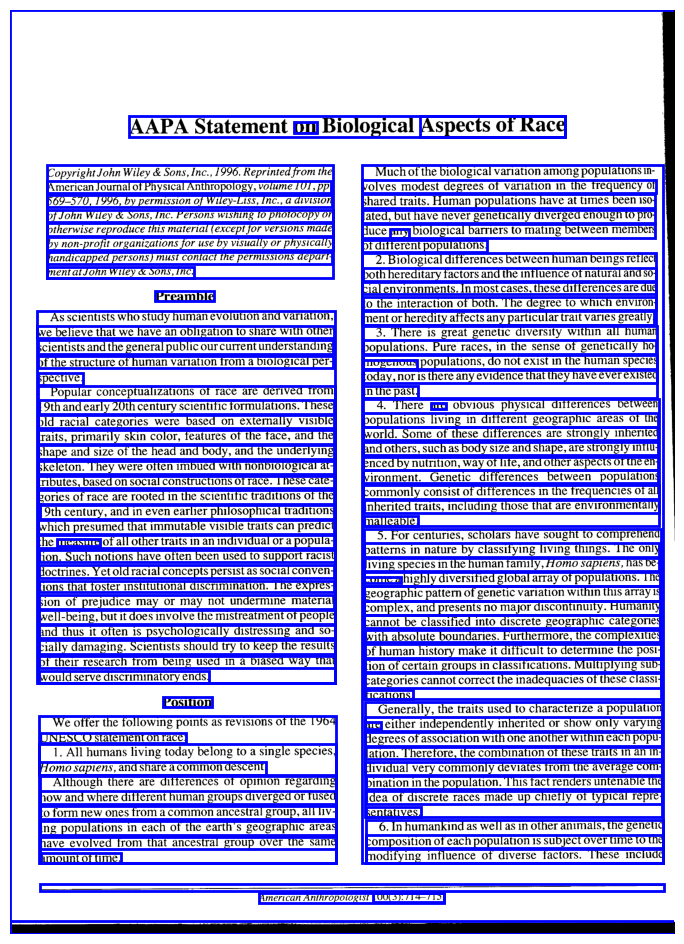

In [98]:
# --- Load image and extract OCR data ---
img = cv2.imread('output_page1.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

data = pytesseract.image_to_data(img, output_type=Output.DICT)
df = pd.DataFrame(data)

# Keep only needed columns
df_NeededData = df[['left', 'top', 'width', 'height']].copy()
df_NeededData = df_NeededData.apply(pd.to_numeric, errors='coerce')

# --- Parameters ---
vertical_tolerance = 8
df_NeededData['top_group'] = (df_NeededData['top'] / vertical_tolerance).round() * vertical_tolerance
df_NeededData = df_NeededData.sort_values(['top_group', 'left']).reset_index(drop=True)

# --- Split into columns ---
column_split = img.shape[1] // 2
df_NeededData['column'] = np.where(df_NeededData['left'] < column_split, 1, 2)

lineIndex = 1
line_boxes = []

def adaptive_threshold(group):
    gaps = np.diff(sorted(group['left']))
    if len(gaps) == 0:
        return 50
    return min(max(np.mean(gaps) * 2.0, 50), 150)

# --- Create line boxes per column ---
for col in [1, 2]:
    col_df = df_NeededData[df_NeededData['column'] == col].sort_values(['top_group', 'left']).reset_index(drop=True)
    group_tops = col_df['top_group'].unique()

    for t in group_tops:
        group = col_df[col_df['top_group'] == t].copy().reset_index(drop=True)
        if group.empty:
            continue

        horiz_thresh = adaptive_threshold(group)
        RP = None
        start_idx = 0

        for i in range(len(group)):
            left = group.loc[i, 'left']
            right = left + group.loc[i, 'width']

            if RP is None:
                RP = right
                continue

            if left - RP > horiz_thresh:
                sub = group.iloc[start_idx:i]
                min_left = sub['left'].min()
                max_right = (sub['left'] + sub['width']).max()
                min_top = sub['top'].min()
                max_bottom = (sub['top'] + sub['height']).max()
                line_boxes.append({
                    'left': min_left,
                    'top': min_top,
                    'width': max_right - min_left,
                    'height': max_bottom - min_top,
                    'line #': lineIndex,
                    'column': col
                })
                lineIndex += 1
                start_idx = i
            RP = right

        sub = group.iloc[start_idx:]
        if not sub.empty:
            min_left = sub['left'].min()
            max_right = (sub['left'] + sub['width']).max()
            min_top = sub['top'].min()
            max_bottom = (sub['top'] + sub['height']).max()
            line_boxes.append({
                'left': min_left,
                'top': min_top,
                'width': max_right - min_left,
                'height': max_bottom - min_top,
                'line #': lineIndex,
                'column': col
            })
            lineIndex += 1

# --- Combine and merge similar lines ---
line_boxes_df = pd.DataFrame(line_boxes).sort_values(['column', 'top']).reset_index(drop=True)
merged_boxes = []
merge_tolerance = 10

for col in [1, 2]:
    col_lines = line_boxes_df[line_boxes_df['column'] == col].sort_values('top').reset_index(drop=True)
    i = 0
    while i < len(col_lines):
        current = col_lines.loc[i].copy()
        j = i + 1
        while j < len(col_lines) and abs(col_lines.loc[j, 'top'] - current['top']) < merge_tolerance:
            nxt = col_lines.loc[j]
            current['left'] = min(current['left'], nxt['left'])
            current['width'] = max(current['left'] + current['width'], nxt['left'] + nxt['width']) - current['left']
            current['top'] = min(current['top'], nxt['top'])
            current['height'] = max(current['top'] + current['height'], nxt['top'] + nxt['height']) - current['top']
            j += 1
        merged_boxes.append(current)
        i = j

merged_boxes_df = pd.DataFrame(merged_boxes).reset_index(drop=True)

# --- Extract text for each box ---
texts = []
for idx, row in merged_boxes_df.iterrows():
    x, y, w, h = int(row['left']), int(row['top']), int(row['width']), int(row['height'])
    roi = img_rgb[y:y+h, x:x+w]
    text = pytesseract.image_to_string(roi, config='--psm 7')
    texts.append(text.strip())

merged_boxes_df['text'] = texts

# --- Save results ---
merged_boxes_df.to_csv('Final_Line_Boxes_Text.csv', index=False)

# --- Plot result (NO yellow numbers now) ---
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img_rgb)

for _, row in merged_boxes_df.iterrows():
    rect = patches.Rectangle(
        (row['left'], row['top']),
        row['width'],
        row['height'],
        linewidth=2,
        edgecolor='blue',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.axis('off')
plt.show()

# Plot the final page with the sentence bounding boxes

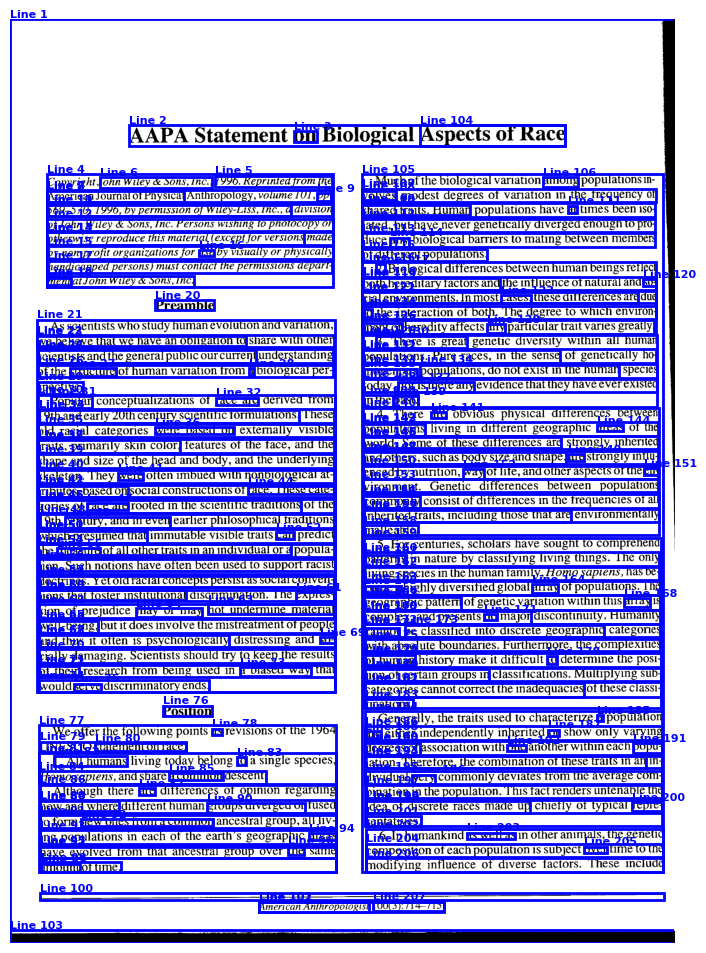

In [99]:

    PNG_NAME = 'output_page1.png'
    img = cv2.imread(PNG_NAME)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img_rgb)

    for idx, row in line_boxes_df.iterrows():
        rect = patches.Rectangle(
            (row['left'], row['top']),
            row['width'],
            row['height'],
            linewidth=2,
            edgecolor='blue',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(row['left'], row['top']-5, f"Line {idx+1}", fontsize=8, color='blue', weight='bold')

    plt.axis('off')
    plt.show()